### 무엇을 해야하는가.

- 음성을 왜 2초로 나누었는가.

- ResNet은 시간축의 특성을 삭제하는 방식으로 작동한다. 말 그래도 이미지의 유사도를 분석하는 것. 그런데 왜 성능이 잘 나온거지?

---

### 어떻게 해결할 수 있는가.

#### 주파수 크기만 모델에 넣으면 어떻게 되지?

1. 음성의 파워를 측정하여 최소가 되는 지점들을 찾는다.

2. 해당 최소가 되는 지점부터 끝 지점까지만 자른다.

3. 길이가 5초가 되도록 padding을 추가한다. + 스펙트럼을 추출하여 각 상태에 따른 모양을 확인해보자.

4. 모델에 입력.

당장해보자.


In [1]:
import os
import wave
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

In [2]:
# Read Wav
def read_wav(file_path):
    with wave.open(file_path, 'r') as wav_file:
        n_channels, sampwidth, framerate, n_frames, comptype, compname = wav_file.getparams()
        audio_data = wav_file.readframes(n_frames)
        audio_data = np.frombuffer(audio_data, dtype=np.int16)

    # Stereo 파일의 경우 mono로 변환
    if n_channels == 2:
        audio_data = (audio_data[::2] + audio_data[1::2]) / 2

    return [audio_data, {'n_channels': n_channels,
                         'sampwidth': sampwidth,
                         'framerate': framerate,
                         'n_frames': n_frames,
                         'comptype': comptype,
                         'compname': compname}]


search_in_sec = 3


# origin_file_path = '/Users/jaewone/developer/tensorflow/baby-cry-classification/origin_data/03-02-04-01-03-150-03-01-01-14.wav'
origin_file_path = '/Users/jaewone/developer/tensorflow/baby-cry-classification/origin_data/hug_56.wav'
audio_data, audio_status = read_wav(origin_file_path)
print(f'file: {origin_file_path}')
for status in audio_status:
    print(f'{status} : {audio_status[status]}')

file: /Users/jaewone/developer/tensorflow/baby-cry-classification/origin_data/hug_56.wav
n_channels : 1
sampwidth : 2
framerate : 16000
n_frames : 259574
comptype : NONE
compname : not compressed


In [3]:
from scipy.signal import stft


def mel_filter_bank(num_filters, fft_size, sample_rate):
    """
    멜 필터뱅크 생성
    """
    # 멜 스케일과 헤르츠 스케일 간의 변환 함수
    def hz_to_mel(hz): return 2595 * np.log10(1 + hz / 700)
    def mel_to_hz(mel): return 700 * (10**(mel / 2595) - 1)

    # 멜 스케일로 끝점 설정
    mel_end = hz_to_mel(sample_rate / 2)
    mel_points = np.linspace(hz_to_mel(0), mel_end, num_filters + 2)
    hz_points = mel_to_hz(mel_points)

    # FFT 주파수 인덱스로 변환
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)

    # 필터뱅크 생성
    filters = np.zeros((num_filters, fft_size // 2 + 1))
    for i in range(1, num_filters + 1):
        filters[i - 1, bin_points[i - 1]:bin_points[i]] = \
            (np.arange(bin_points[i - 1], bin_points[i]) -
             bin_points[i - 1]) / (bin_points[i] - bin_points[i - 1])
        filters[i - 1, bin_points[i]:bin_points[i + 1]] = 1 - \
            (np.arange(bin_points[i], bin_points[i + 1]) -
             bin_points[i]) / (bin_points[i + 1] - bin_points[i])
    return filters


def get_log_mel_spectogram(audio_data, framerate, num_filters=40, nperseg=2048, noverlap=1024, nfft=2048):
    # STFT 계산
    _, _, Zxx = stft(audio_data, fs=framerate, nperseg=nperseg,
                     noverlap=noverlap, nfft=nfft)
    magnitude = np.abs(Zxx)

    # 로그 멜 스펙트럼 추출
    num_filters = num_filters
    filters = mel_filter_bank(num_filters, 2048, framerate)
    mel_spectrum = np.dot(filters, magnitude)
    log_mel_spectrum = np.log(mel_spectrum + 1e-9)  # log 0을 피하기 위한 작은 값 추가
    return log_mel_spectrum


def get_mel_power(log_mel_spectrum):
    # 로그 멜 스펙트럼의 파워 계산
    return np.sum(log_mel_spectrum**2, axis=0)


def show_mel_power(power, dot_list=[], dot_color='red', dot_label=''):
    # 파워 시각화
    plt.figure(figsize=(12, 5))
    plt.plot(power)
    plt.title("Log Mel Spectrum Power")
    plt.xlabel("Time Frame")
    plt.ylabel("Power")

    if (len(dot_list) > 0):
        plt.scatter(dot_list, power[dot_list],
                    color=dot_color, label=dot_label)
        plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()


log_mel_spectrum = get_log_mel_spectogram(
    audio_data, audio_status['framerate'])
print(log_mel_spectrum.shape)
power = get_mel_power(log_mel_spectrum)
# show_mel_power(power)

(40, 255)


In [4]:
# def minima_points(power_array, n):
#     """
#     주어진 파워 배열에서 최솟값이 되는 n개의 시점을 반환하는 함수.

#     Parameters:
#     - power_array: 파워 배열
#     - n: 반환할 최솟값의 개수

#     Returns:
#     - min_indices: 최솟값이 되는 n개의 시점의 리스트
#     """
#     return np.argsort(power_array)[:n].tolist()


# # 파워에서 최솟값 10개 찾기
# min_indices = minima_points(power, 4)
# print(min_indices)

# show_mel_power(power, dot_list=min_indices, dot_label='Top 10 Minima')

[27, 38, 69, 116, 145, 159, 197, 212, 254]


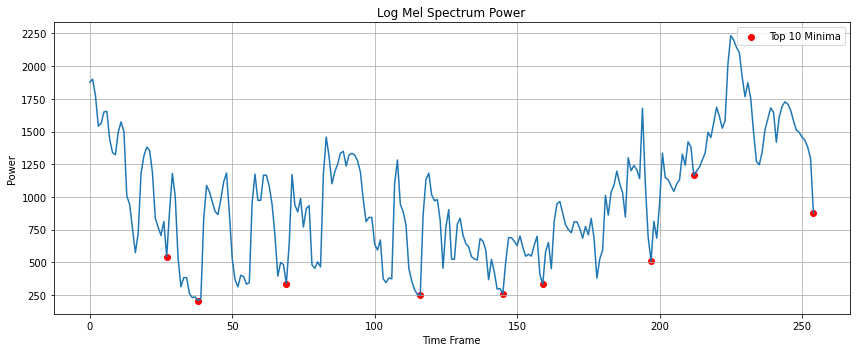

In [5]:
def get_interval_min_sec(power, sec: int = 1):
    interval_sec = int(10 * sec)
    min_sec_list = []
    for i in range(0, len(power) + 1, interval_sec):
        min_sec = i + np.argsort(power[i:i+interval_sec])[0]
        min_sec_list.append(min_sec)
    return min_sec_list


min_sec_list = get_interval_min_sec(power, sec=search_in_sec)

print(min_sec_list)
show_mel_power(power, dot_list=min_sec_list, dot_label='Top 10 Minima')

In [6]:
def split_audio_on_indices(audio_data, power, indices):
    """
    주어진 인덱스를 기준으로 오디오 데이터를 여러 부분으로 나누는 함수.

    Parameters:
    - audio_data: 오디오 데이터 배열
    - indices: 분할할 시점의 리스트

    Returns:
    - audio_segments: 나눈 오디오 데이터의 리스트
    """
    # STFT를 통해 구한 시점을 오디오 샘플의 시점으로 변환
    nperseg = 2048
    noverlap = 1024
    samples_per_frame = (len(audio_data) - nperseg) / (len(power) - 1)
    sample_indices = [int(index * samples_per_frame) for index in indices]

    audio_segments = []
    prev_index = 0
    for index in sample_indices:
        segment = audio_data[prev_index:index]
        audio_segments.append(segment)
        prev_index = index
    audio_segments.append(audio_data[prev_index:])  # 마지막 세그먼트 추가

    return audio_segments


audio_segments_sec = split_audio_on_indices(audio_data, power, min_sec_list)

# 세그먼트의 길이가 0인 것은 제외한다.
pop_index_list = []
for i in range(len(audio_segments_sec)):
    if (len(audio_segments_sec[i]) == 0):
        pop_index_list.append(i)
for index in pop_index_list:
    audio_segments_sec.pop(index)

# 각 세그먼트의 길이 확인
segment_lengths = [len(segment) for segment in audio_segments_sec]
segment_lengths

[27374, 11153, 31430, 47653, 29402, 14195, 38527, 15208, 42584, 2048]

In [7]:
def save_audio_segments_as_wav(audio_segments, output_dir, prefix, sampwidth, framerate):
    """
    주어진 오디오 세그먼트들을 WAV 파일로 저장하는 함수.

    Parameters:
    - audio_segments: 나눈 오디오 데이터의 리스트
    - output_dir: 출력 디렉토리 경로
    - prefix: 저장할 파일의 접두사

    Returns:
    - filepaths: 저장된 파일의 경로 리스트
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    filepaths = []
    for i, segment in enumerate(audio_segments):
        filename = f"{prefix}_segment_{i}.wav"
        filepath = os.path.join(output_dir, filename)
        with wave.open(filepath, 'wb') as wav_file:
            wav_file.setnchannels(1)
            wav_file.setsampwidth(sampwidth)
            wav_file.setframerate(framerate)
            wav_file.writeframes(segment.tobytes())
        filepaths.append(filepath)

    return filepaths


# 오디오 세그먼트를 WAV 파일로 저장
output_dir = '/Users/jaewone/developer/tensorflow/baby-cry-classification/aa'
saved_filepaths = save_audio_segments_as_wav(
    audio_segments=audio_segments_sec,
    output_dir=output_dir,
    prefix=origin_file_path.rsplit('/', 1)[1].rsplit('.')[0],  # file name
    sampwidth=audio_status['sampwidth'],
    framerate=audio_status['framerate'],
)

saved_filepaths[:3]

['/Users/jaewone/developer/tensorflow/baby-cry-classification/aa/hug_56_segment_0.wav',
 '/Users/jaewone/developer/tensorflow/baby-cry-classification/aa/hug_56_segment_1.wav',
 '/Users/jaewone/developer/tensorflow/baby-cry-classification/aa/hug_56_segment_2.wav']

/Users/jaewone/ENTER/envs/tf25/lib/python3.9/site-packages/numba/cpython/hashing.py:482: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


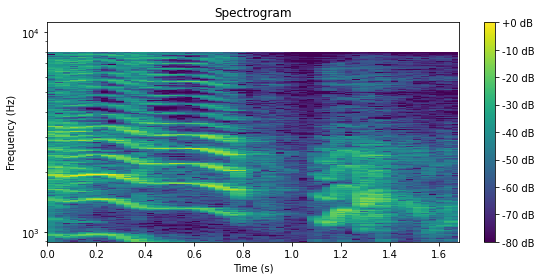

Duration of the audio file: 1.71 -> 1.45


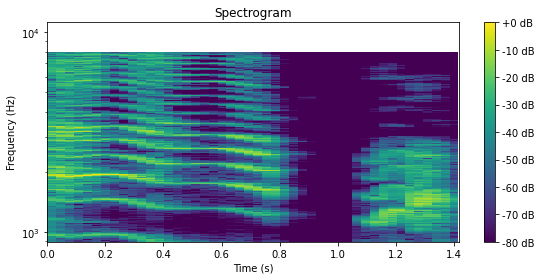

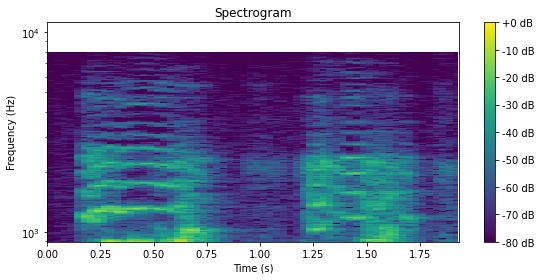

Duration of the audio file: 1.96 -> 1.69


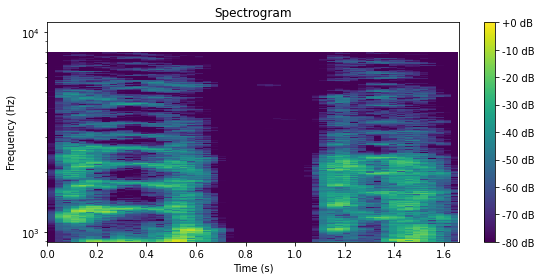

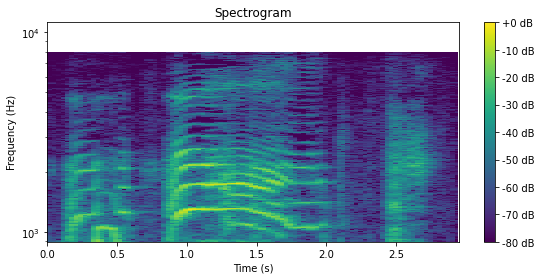

Duration of the audio file: 2.98 -> 2.67


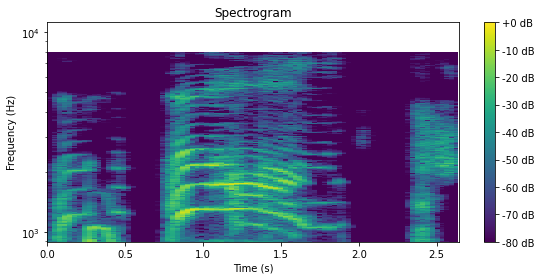

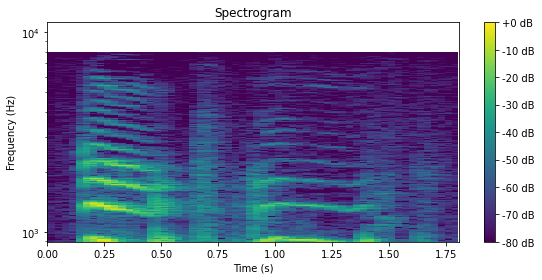

Duration of the audio file: 1.84 -> 1.45


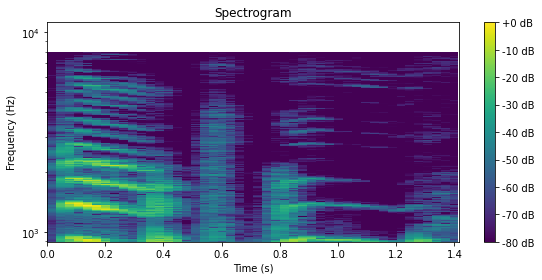

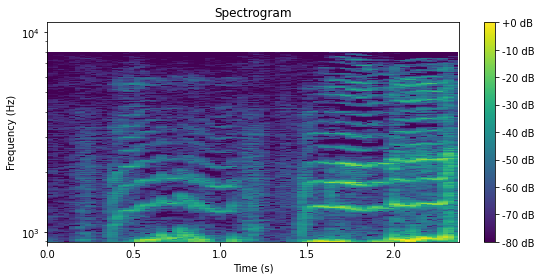

Duration of the audio file: 2.41 -> 2.07


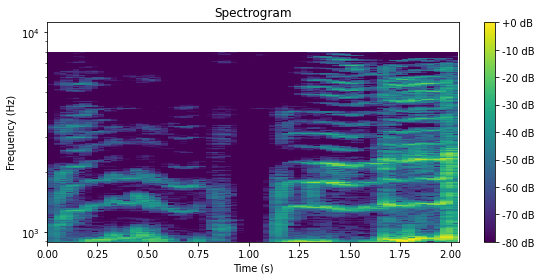

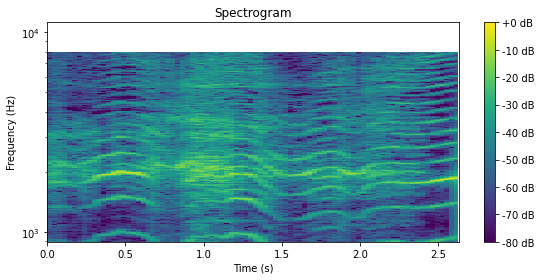

Duration of the audio file: 2.66 -> 2.34


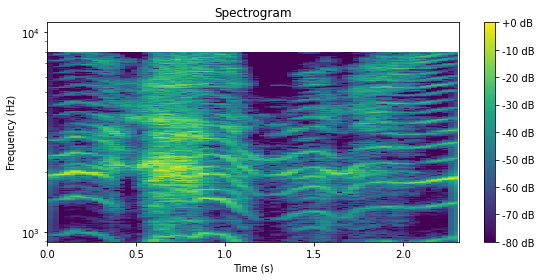

In [8]:
from trans_data import trim_audio, reduced_base_noise


def show_spectrum(y, sr):
    # STFT 계산
    D = librosa.amplitude_to_db(abs(librosa.stft(y)), ref=np.max)

    # 시간과 주파수 축을 위한 값들 계산
    times = np.linspace(0, len(y)/sr, num=D.shape[1], endpoint=False)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=2048)

    # 스펙트럼 시각화
    plt.figure(figsize=(8, 4))
    plt.imshow(D, aspect='auto', origin='lower', extent=[
               times.min(), times.max(), freqs.min(), freqs.max()])
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Spectrogram')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()


target_files = []

for file_path in saved_filepaths:
    # WAV 파일 로드
    y, sr = librosa.load(file_path, sr=None)

    # 파일의 길이(초) 출력
    origin_duration = librosa.get_duration(y=y, sr=sr)
    if origin_duration > search_in_sec/2:
        target_files.append(file_path)
        show_spectrum(y, sr)
        trim_audio(file_path, inplace=True, frame_size=1000)
        reduced_base_noise(file_path, inplace=True)

        y, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        print(
            f"Duration of the audio file: {origin_duration:.2f} -> {duration:.2f}")
        show_spectrum(y, sr)

Duration of the audio file: 16.22 seconds


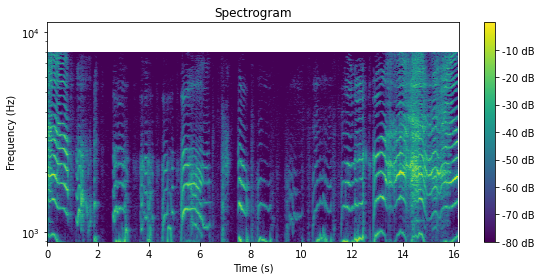

In [9]:
# 전체 음성의 멜 스펙트럼

# WAV 파일 로드
y, sr = librosa.load(origin_file_path, sr=None)

# 파일의 길이(초) 출력
duration = librosa.get_duration(y=y, sr=sr)
if duration > 1:
    print(f"Duration of the audio file: {duration:.2f} seconds")

    show_spectrum(y, sr)

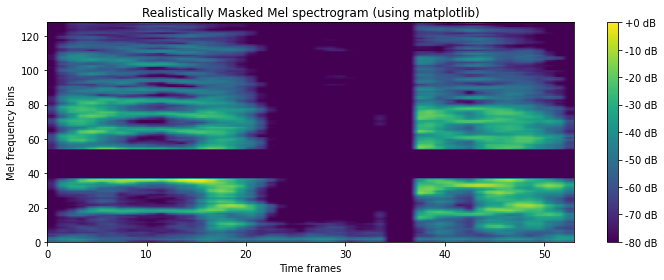

In [54]:
def mask_melspectrogram(file_path, 
                        freq_mask_num=2, 
                        time_mask_num=2, 
                        freq_masking_max_percentage=0.15, 
                        time_masking_max_percentage=0.3):
    
    # 1. Load the audio file
    y, sr = librosa.load(file_path, sr=None)

    # 2. Extract mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

    num_freq_bins = mel_spectrogram.shape[0]
    num_time_bins = mel_spectrogram.shape[1]

    # 3. Apply masking
    # Frequency masking
    for _ in range(freq_mask_num):
        freq_start = np.random.randint(0, num_freq_bins)
        freq_length = np.random.randint(
            0, int(num_freq_bins * freq_masking_max_percentage))
        freq_end = min(mel_spectrogram.shape[0], freq_start + freq_length)
        mel_spectrogram[freq_start:freq_end, :] = 0

    # Time masking
    for _ in range(time_mask_num):
        time_start = np.random.randint(0, num_time_bins)
        time_length = np.random.randint(
            0, int(num_time_bins * time_masking_max_percentage))
        time_end = min(mel_spectrogram.shape[1], time_start + time_length)
        mel_spectrogram[:, time_start:time_end] = 0

    return mel_spectrogram

def show_masked_mel(db_masked_mel):
    plt.figure(figsize=(10, 4))
    plt.imshow(db_masked_mel, origin='lower', aspect='auto',
            extent=[0, db_masked_mel.shape[1], 0, db_masked_mel.shape[0]])
    plt.colorbar(format='%+2.0f dB')
    plt.title('Realistically Masked Mel spectrogram (using matplotlib)')
    plt.xlabel('Time frames')
    plt.ylabel('Mel frequency bins')
    plt.tight_layout()
    plt.show()


# Extract and mask the melspectrogram
masked_mel_spectrogram_realistic = mask_melspectrogram(
    target_files[1],
    freq_mask_num=1,
    time_mask_num=1,
    freq_masking_max_percentage=0.15,
    time_masking_max_percentage=0.1
)

# Convert the mel spectrogram to decibels for visualization
db_masked_mel = librosa.power_to_db(
    masked_mel_spectrogram_realistic, ref=np.max)

show_masked_mel(db_masked_mel)


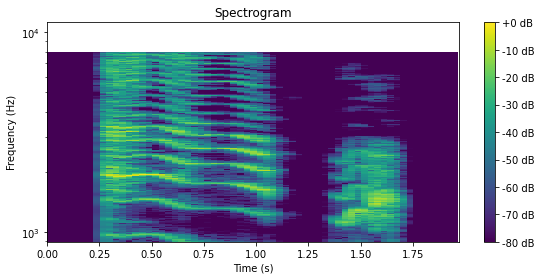

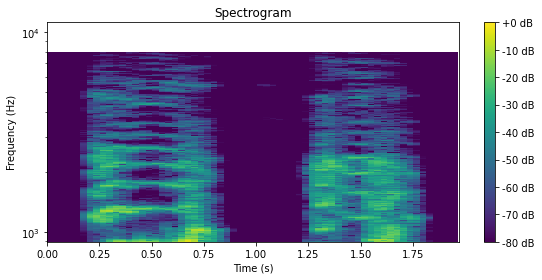

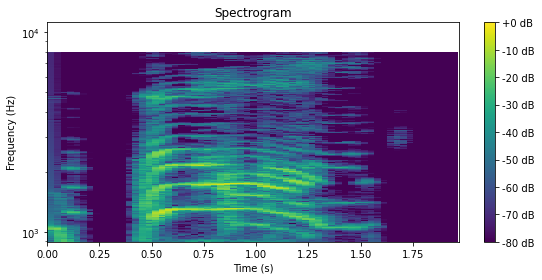

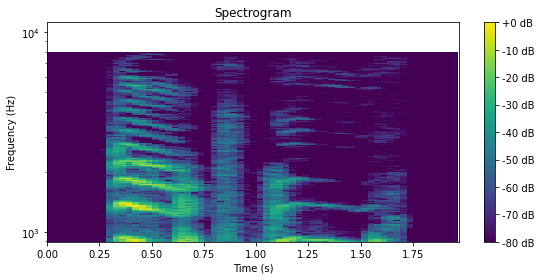

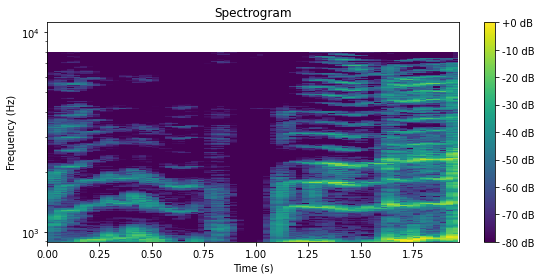

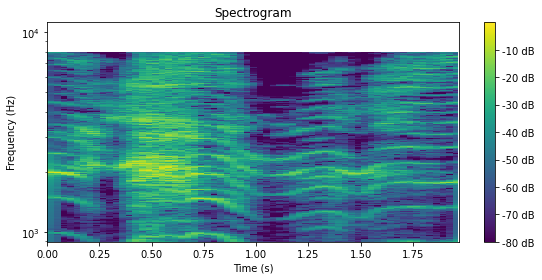

In [10]:
def pad_audio_to_length(input_path, output_path, target_duration):
    """
    wav 파일을 target_duration 길이로 맞춘다. 
    음성의 중심을 기준으로 target_duration보다 짧을 경우 앞뒤에 Padding을 추가하며 
    음성의 중심을 기준으로 target_duration보다 길 경우 앞뒤를 자른다.
    """
    # WAV 파일 읽기
    y, sr = librosa.load(input_path, sr=None)

    # 현재 오디오 파일의 길이 확인
    current_duration = len(y) / sr

    # target_duration과 비교하여 패딩 또는 trimming 필요 여부 확인
    total_samples = int(target_duration * sr)

    if len(y) < total_samples:
        # 패딩 필요
        padding_samples = total_samples - len(y)
        left_padding = padding_samples // 2
        right_padding = padding_samples - left_padding
        processed_audio = np.pad(
            y, (left_padding, right_padding), mode='constant')
    else:
        # trimming 필요
        excess_samples = len(y) - total_samples
        left_trim = excess_samples // 2
        right_trim = excess_samples - left_trim
        processed_audio = y[left_trim:-right_trim]

    # 변환된 데이터를 WAV 파일로 저장
    sf.write(output_path, processed_audio, sr)

    return output_path


output_dir = '/Users/jaewone/developer/tensorflow/baby-cry-classification/sec_test_result'
if not (os.path.exists(output_dir)):
    os.mkdir(output_dir)

for file_path in target_files:
    output_path = os.path.join(output_dir, file_path.rsplit('/', 1)[1])
    pad_audio_to_length(file_path, output_path, search_in_sec-1)
    y, sr = librosa.load(output_path, sr=None)
    show_spectrum(y, sr)